# Hard Disk Drive (HDD) survival analysis in python

## Part III: Cox PH modelling

Date: Diciembre 2017

Autor: [Alvaro Calle Cordon](www.linkedin.com/in/alvarocallecordon)

Notebook uses Python 2.7

## Descripción del notebook

In this notebook we demonstrate a standard semi-parametric regression method to create a model of harddrive failures. This model can be tested for accuracy and used for prediction.

In `HDD_survival_II_KM` we used a very basic non-parametric model (Kaplan-Meier) to produce what is effectively a simple count of events over time. These Kaplan-Meier models are extremely quick to run but limited by simplicity; whilst we can compare the empirical survival functions amongst different subsets of the data, we can't easily make comparative statements nor make predictive statements for new unseen data.

What we want is a regression model which takes not only the `time_to_event` and `event_outcome` features as before, but also a potentially unlimited set of exogenous features to predict the survival or hazard rate at each point in time. The Cox Proportional Hazards model (Cox PH) is a such a *survival regression* model.

## Documentación

- https://github.com/MustafaOguz/Survival_Analysis
- https://github.com/search?l=Python&q=survival+analysis&type=Repositories&utf8=%E2%9C%93
- https://github.com/eduardoleon/survival
- https://github.com/jaredleekatzman/DeepSurv
- https://github.com/CamDavidsonPilon/lifelines
- http://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html
- http://blog.applied.ai/survival-analysis-part-4/

## Cox Proportional Hazards Modelling

The [Cox PH model](https://en.wikipedia.org/wiki/Proportional_hazards_model) gives a semi-parametric method of estimating the hazard function $\lambda$ at time $t$ given a baseline hazard that's modified by a set of covariates:

$$
\lambda(t|X) = \lambda_0(t)\ \exp{(\beta_1 X_1 + \cdots + \beta_p X_p)} = \lambda_0(t)\exp(\beta X )\, ,
$$


where $\lambda_0(t)$ is the non-parametric baseline hazard function and $\beta X$ is a linear parametric model using features of the individuals, transformed by an exponential function.

The algorithm runs quite quickly, performing iterative partial regression of the time-dependent $\lambda_0(t)$, and the feature-dependent $\exp(\beta X)$, repeated until convergence.

The big strength of Cox PH is to:

- allow us to compare the relative hazard rates of the different features by comparing the $\beta$ coefficients, and 
- to compute a predicted survival function for new datapoints simply by plugging the details into the model.

One big weakness of the Cox PH is that the $\beta$ values are assumed constant over all time, which is often untrue, more of which later.

Lets continue our investigation into the hard-drive failure data, and as ever, the plots and tables in the notebook are accompanied by detailed comments:

## Setup

### Initial setups

In [4]:
# plots in the notebook
%matplotlib inline

# fire ipython console
#%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

### Libraries

In [5]:
from collections import OrderedDict
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lifelines as sa
from lifelines.utils import concordance_index, k_fold_cross_validation
import patsy as pt

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid')
cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 10, 6

np.random.seed(0)

## Loading the data

We load here the table `drive_survival_prepared` generated in the previous notebook `HDD_survival_I_Preparation` which has been stored in the sqlitle database `drive_stats.db`.

In [6]:
# Where am I?
%pwd

u'/home/alvaro/Documentos/Analytics/Survival'

In [7]:
# check drive_stats.db is in the current directory
%ls

code.py             drive_survival.sql~
data_Q3_2016/       HDD_survival_III_CoxPH.ipynb
data_Q3_2016.zip    HDD_survival_II_KM.ipynb
docs_Q3_2016/       HDD_survival_I_Preparation.ipynb
docs_Q3_2016+.zip   KM_code.png
drive_stats.db      survival_r_vs_python.ipynb
drive_survival.sql  temp-plot.html


**SQL connector** 

In [8]:
cnx = sqlite3.connect('drive_stats.db')
csr = cnx.cursor()

**Check tables in database**

In [9]:
csr.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(csr.fetchall())

[(u'drive_stats',), (u'drive_survival',), (u'drive_survival_prepared',)]


**Pre-processed data from sqlitle db**

In [10]:
query = 'select * from drive_survival_prepared'
df = pd.read_sql(query, con=cnx, index_col='diskid', parse_dates=['mindate','maxdate'])

In [11]:
print df.shape

(67340, 11)


In [12]:
df.head()

,model,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,
5XW00J2Z,ST31500541AS,2016-07-21,2016-09-30,62,46815,48301,0,SEAGATE,1.5TB,201607,201609
5XW029ZZ,ST31500541AS,2016-07-21,2016-09-30,62,50682,52168,0,SEAGATE,1.5TB,201607,201609
5XW02BHJ,ST31500541AS,2016-07-21,2016-09-30,62,45703,47362,0,SEAGATE,1.5TB,201607,201609
5XW02L6V,ST31500541AS,2016-07-21,2016-09-30,62,54121,55780,0,SEAGATE,1.5TB,201607,201609
5XW02N56,ST31500541AS,2016-07-21,2016-09-30,62,50686,52172,0,SEAGATE,1.5TB,201607,201609


## Cox Proportional Hazard Model

### Transform raw dataframe into design matrix & model specification

The first step is to transform the row-based dataframe into a design matrix $\mathbf{X}$ for the Cox PH model. We will use the [patsy](https://pypi.python.org/pypi/patsy) package and a model-specification string `manufacturer + capacity`. This modelspec is simply a GLM and the flexible approach afforded by Cox PH lets us declare any modelspec we wish, for example rather than $\beta_0 X_0 + \beta_1 X_1 + \beta_2 X_2$ we could try $\beta_0 (X0 + X_0^2) + \beta_1 X_1 ∗ \beta_2 X_2$ etc.


Note that by default, the first factor in each feature will be used in the intercept, which sets the baseline hazard rate, to which all other factor combinations are compared. In this case, that will be HGST and 1.5TB.

In [17]:
modelspec = 'manufacturer + capacity'

dft = pt.dmatrix(modelspec, df, return_type='dataframe')
design_info = dft.design_info
dft = dft.join(df[['maxhours','failed']])

## NOTE: CoxPHFitter expects reduced-rank design matrix WITHOUT intercept
del dft['Intercept']
dft.head().T

diskid,5XW00J2Z,5XW029ZZ,5XW02BHJ,5XW02L6V,5XW02N56
manufacturer[T.SEAGATE],1.0,1.0,1.0,1.0,1.0
manufacturer[T.WDC],0.0,0.0,0.0,0.0,0.0
capacity[T.2.0TB],0.0,0.0,0.0,0.0,0.0
capacity[T.3.0TB],0.0,0.0,0.0,0.0,0.0
capacity[T.4.0TB],0.0,0.0,0.0,0.0,0.0
capacity[T.6.0TB],0.0,0.0,0.0,0.0,0.0
maxhours,48301.0,52168.0,47362.0,55780.0,52172.0
failed,0.0,0.0,0.0,0.0,0.0


**NOTE:**

The previous is a view of the top 5 rows of the design matrix, transposed so it fits easier in view. It can be seen the boolean representation of the feature values for each disk, for example:
- diskid 5XW00J2Z is a Seagate 1.5TB drive with 48301.0 hours of power-on and no failure, and so on.

### Fit CoxPH

The fit() method runs the CoxPH partial regression and stores the results on the cx object

In [20]:
cx = sa.CoxPHFitter()
cx.fit(df=dft, duration_col='maxhours', event_col='failed', show_progress=True)

Iteration 1: norm_delta = 0.52650, step_size = 0.50000, ll = -3511.41429
Iteration 2: norm_delta = 0.33304, step_size = 0.49500, ll = -3366.69927
Iteration 3: norm_delta = 0.27801, step_size = 0.49005, ll = -3316.48355
Iteration 4: norm_delta = 0.27261, step_size = 0.48515, ll = -3292.08845
Iteration 5: norm_delta = 0.28459, step_size = 0.48030, ll = -3279.19489
Iteration 6: norm_delta = 0.28483, step_size = 0.47550, ll = -3272.24144
Iteration 7: norm_delta = 0.24937, step_size = 0.47074, ll = -3268.59664
Iteration 8: norm_delta = 0.18447, step_size = 0.46603, ll = -3266.85738
Iteration 9: norm_delta = 0.11927, step_size = 0.46137, ll = -3266.13821
Iteration 10: norm_delta = 0.07113, step_size = 0.45676, ll = -3265.87749
Iteration 11: norm_delta = 0.04068, step_size = 0.45219, ll = -3265.79076
Iteration 12: norm_delta = 0.02282, step_size = 0.44767, ll = -3265.76319
Iteration 13: norm_delta = 0.01271, step_size = 0.44319, ll = -3265.75460
Iteration 14: norm_delta = 0.00708, step_size =

<lifelines.CoxPHFitter: fitted with 67340 observations, 67001 censored>

### View the baseline hazard rate:

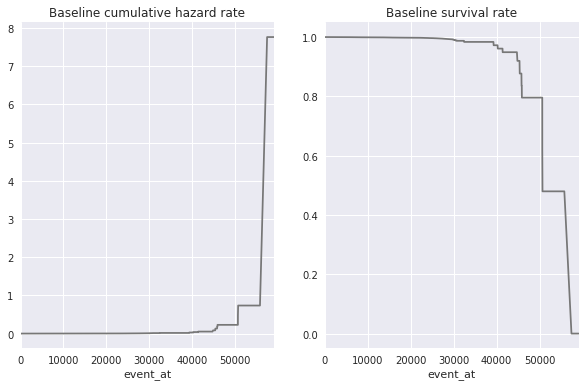

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, sharex=True)
cx.baseline_cumulative_hazard_.plot(ax=axes[0,0], legend=False
                ,title='Baseline cumulative hazard rate')
cx.baseline_survival_.plot(ax=axes[0,1], legend=False
                ,title='Baseline survival rate')

**Observation**:

The above figures show the baseline cumulative hazard rate $\Lambda = \sum_t \lambda_0(t)$  and the computed baseline survival rate $S =e^{-\Lambda}$.

### View the summary of model coefficients

In [22]:
cx.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
manufacturer[T.SEAGATE],2.457392,11.674323,0.233219,10.536857,5.841887e-26,2.000191,2.914593
manufacturer[T.WDC],4.088040,59.622897,0.398838,10.249878,1.184933e-24,3.306160,4.869919
capacity[T.2.0TB],-0.769706,0.463149,1.028735,-0.748207,4.543354e-01,-2.786432,1.247020
capacity[T.3.0TB],1.522484,4.583597,1.121083,1.358048,1.744484e-01,-0.675281,3.720249
capacity[T.4.0TB],4.209740,67.339045,1.183343,3.557499,3.744030e-04,1.889921,6.529559
capacity[T.6.0TB],3.673655,39.395619,1.189264,3.089014,2.008218e-03,1.342227,6.005082


In [31]:
np.exp(4.2-1.5)

14.879731724872837

The proportional nature of the hazard coefficients can be seen clearly.

**Observations**:

- Manufacturers:

    - A typical Seagate drive has a mean hazard rate $\exp(2.5) = 11.7x$ that of an HGST drive (HGST is on the baseline for this model), and a WDC drive has a hazard rate  $\exp(4.1) = 60.3x$ that of an HGST drive

- Capacities:

    - A typical 3TB drive would appear to be 4.6 x more likely to fail than a typical 1.5TB drive.
    - Combining features, our model tells us a Seagate 3TB drive has a hazard rate  $(11.7+4.6=16)x$ that of the baseline, which is  14x larger than an HGST 3TB drive, and  50x smaller than a WDC 3TB drive  $(59.6+4.6=64.2)x$.
    - A 4TB drive would appear to be $exp(4.2)x = 67.3x$ more likely to fail than a 1.5TB drive, but compared with a 3TB drive, is $exp(4.2-1.5)x=14.9x$ as likely to fail: an increase in reliability and capacity.
    
Lets view those ranges on the $\exp(\beta)$ coefficients:

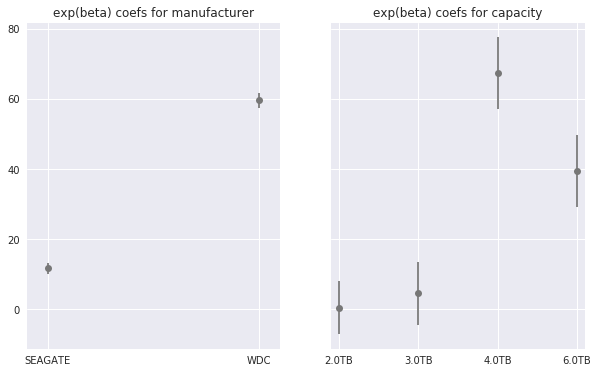

In [32]:
smy = cx.summary.copy().reset_index()
smy['type'] = smy['index'].apply(lambda x: 'mfr' if x[:1]=='m' else 'cap')
smy['err'] = smy['upper 0.95'] - smy['coef']

fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(10,6), sharey=True)
fig.canvas.draw()
for j, sel in enumerate(['mfr','cap']):
    smysub = smy.loc[smy['type']==sel].copy()
    axes[0,j].errorbar(x=np.arange(smysub.shape[0]), y=np.exp(smysub['coef'])
                       ,marker='o', linestyle='', yerr=np.exp(smysub['err']))
    axes[0,j].set_title('exp(beta) coefs for {}'.format(['manufacturer','capacity'][j]))
    axes[0,j].set_xlim([-0.1, len(smysub) - 0.9])
    axes[0,j].set_xticks(np.arange(smysub.shape[0]))
    axes[0,j].set_xticklabels([t.split('[')[1][2:-1] for t in smysub['index']])

**Observe**:

- The proportional hazards really are very different amongst the drives
- The uncertainty in the beta coeffs is far more clear in this view, for example

### Evaluate model performance using concordance

The `lifelines` package has a couple of convenience functions to let us very easily evaluate model performance:

- `concordance_index` which computes the concordance index - the overall probability that predicted and actual events occur in the same ranked order (see more at http://papers.nips.cc/paper/3375-on-ranking-in-survival-analysis-bounds-on-the-concordance-index.pdf).

- `k_fold_cross_validation` which divides the dataset $n$ into two subsets with $n(k-1)/k$ rows and $n/k$ rows, then uses the larger set to train and the smaller set to test the model using the concordance measure. The 'fold' part means it runs repeatedly over different subsets so that each row in the data is used for training and for test.

Paraphrasing the lifelines docs: concordance is a generalisation of the area-under-curve (AUC) measure and interpreted similarly:

- 0.5 is the expected result from random predictions,
- 1.0 is perfect concordance and,
- 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)

A concordance score between 0.6 and 0.8 would indicate a well-performing model.

In [34]:
cx1 = sa.CoxPHFitter()
scores = k_fold_cross_validation(cx1, dft, k=5,
                                 duration_col='maxhours',
                                 event_col='failed', 
                                 predictor='predict_expectation')

(0.5, 1)

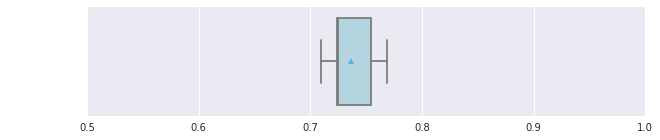

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,2))
sns.boxplot(scores, color='lightblue', ax=axes, showmeans=True)
axes.annotate('{:.3f}'.format(np.mean(scores)), xy=(np.mean(scores),1), xycoords='data',
              xytext=(10, 10), textcoords='offset points', color='r', fontsize=12)
axes.set_xlim([0.5,1])